In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
tf.__version__

'2.5.0'

In [2]:
def images_from_folder_and_annotations(folder, annotations):
    import pandas as pd
    annotations = pd.read_csv(annotations)
    if annotations["Value"].dtype == "object":
        annotations["Value"] = pd.to_numeric(annotations["Value"].str.replace(',', '.'),errors='coerce')
    TARGETDIMS = (480, 640)
    import tensorflow as tf
    import numpy as np
    import os
    images = []
    values = []
    for idx, row in annotations.iterrows():
        path = os.path.join(folder, row["File"])
        image = (np.array(tf.keras.preprocessing.image.load_img(path, target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) 
        value = row["Value"]
        images.append(image)
        values.append(value)
    images = np.array(images)
    values = np.array(values)
    return (images, values, annotations)

In [3]:
training_x, training_y, training_annotations = images_from_folder_and_annotations("shopping_coco/images", "shopping_coco/annotations/values_images.csv")
training_annotations.head()

,File,Value
0,photo_1@02-05-2020_11-15-55.jpg,35.85
1,photo_2@02-05-2020_13-25-27.jpg,2.48
2,photo_3@02-05-2020_13-26-13.jpg,5.35
3,photo_4@02-05-2020_13-26-49.jpg,2.97
4,photo_5@04-05-2020_09-53-52.jpg,2.64


In [4]:
pretraining_x, pretraining_y, pretraining_annotations = images_from_folder_and_annotations("create_images/images", "create_images/images/values.csv")
pretraining_annotations.head()

,File,Value
0,0.jpg,5.15
1,1.jpg,46.89
2,2.jpg,4.51
3,3.jpg,29.97
4,4.jpg,8.17


In [5]:
digits_x, digits_y, digits_annotations = images_from_folder_and_annotations("create_images/digits", "create_images/digits/values.csv")
pretraining_annotations.head()

,File,Value
0,0.jpg,5.15
1,1.jpg,46.89
2,2.jpg,4.51
3,3.jpg,29.97
4,4.jpg,8.17


In [16]:
import tensorflow.keras.layers as K
model = tf.keras.Sequential()
model.add(K.InputLayer((480, 640, 1)))
model.add(K.Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Conv2D(filters=32, kernel_size=(2,2), activation="relu"))
model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Conv2D(filters=32, kernel_size=(2,2), activation="relu"))
#model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Flatten())
model.add(K.Dense(256, activation="relu"))
model.add(K.Dropout(rate=0.1))
model.add(K.Dense(128, activation="relu"))
model.add(K.Dropout(rate=0.1))
model.add(K.Dense(64, activation="relu"))
model.add(K.Dropout(rate=0.1))
#for i in range(10):
model.add(K.Dense(32, activation="relu"))
model.add(K.Dropout(rate=0.1))
model.add(K.Dense(16, activation="relu"))
model.add(K.Dropout(rate=0.1))
model.add(K.Dense(1, activation="relu"))
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 478, 638, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 239, 319, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 237, 317, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 118, 158, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 117, 157, 32)      4128      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 58, 78, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 57, 77, 32)       

In [17]:
class haltCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(epoch % 10 == 0):
        print("Epoch {} mae {} val_mae {}".format(epoch, logs.get('mae'), logs.get('val_mae')))
    if(logs.get('mae') < 0.1):
        print("Reached mae < 0.1 (was {})".format(logs.get('mae')))
        self.model.stop_training = True

stopCallback = haltCallback()


model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(digits_x, digits_y, batch_size=10, epochs=1000, validation_split=0.1, steps_per_epoch=1, verbose=0, callbacks=[stopCallback])

Epoch 0 mae 6.5 val_mae 4.392000198364258
Epoch 10 mae 2.23542857170105 val_mae 2.982038974761963
Epoch 20 mae 3.388045072555542 val_mae 2.614760160446167
Epoch 30 mae 3.9404349327087402 val_mae 2.487987756729126
Epoch 40 mae 2.305318832397461 val_mae 2.575058937072754
Epoch 50 mae 2.8771557807922363 val_mae 2.5732359886169434
Epoch 60 mae 2.9604384899139404 val_mae 2.615112543106079
Epoch 70 mae 4.704860687255859 val_mae 2.4879748821258545
Epoch 80 mae 3.204331874847412 val_mae 2.7382736206054688
Epoch 90 mae 2.493035078048706 val_mae 2.487948417663574
Epoch 100 mae 1.9893169403076172 val_mae 2.551445722579956
Epoch 110 mae 4.538320064544678 val_mae 2.8129444122314453
Epoch 120 mae 2.922823667526245 val_mae 2.493337392807007
Epoch 130 mae 3.2416598796844482 val_mae 2.5329411029815674
Epoch 140 mae 1.501197338104248 val_mae 2.5016634464263916
Epoch 150 mae 2.8879716396331787 val_mae 2.548179864883423
Epoch 160 mae 2.542340040206909 val_mae 2.487884521484375
Epoch 170 mae 1.734148383140

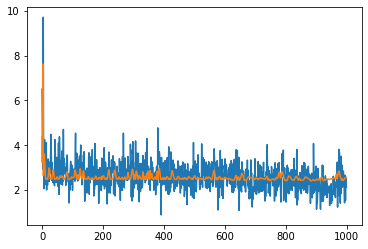

In [18]:
plt.figure()
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.show()

In [19]:
class haltCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(epoch % 10 == 0):
        print("Epoch {} mae {} val_mae {}".format(epoch, logs.get('mae'), logs.get('val_mae')))
    if(logs.get('mae') < 0.1):
        print("Reached mae < 0.1 (was {})".format(logs.get('mae')))
        self.model.stop_training = True

stopCallback = haltCallback()


#model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(pretraining_x, pretraining_y, batch_size=10, epochs=1000, validation_split=0.1, steps_per_epoch=1, verbose=0, callbacks=[stopCallback])

Epoch 0 mae 42.47266387939453 val_mae 56.47213363647461
Epoch 10 mae 43.96016311645508 val_mae 31.872909545898438
Epoch 20 mae 36.68817901611328 val_mae 35.2614631652832
Epoch 30 mae 43.68623352050781 val_mae 31.96266746520996
Epoch 40 mae 35.281715393066406 val_mae 31.859695434570312
Epoch 50 mae 34.41147994995117 val_mae 34.147342681884766
Epoch 60 mae 29.667428970336914 val_mae 32.18056869506836
Epoch 70 mae 42.25856399536133 val_mae 32.15122985839844
Epoch 80 mae 27.83356285095215 val_mae 31.803314208984375
Epoch 90 mae 50.17601776123047 val_mae 31.766321182250977
Epoch 100 mae 26.502777099609375 val_mae 36.15327835083008
Epoch 110 mae 30.25198745727539 val_mae 32.0544548034668
Epoch 120 mae 41.571022033691406 val_mae 32.00102615356445
Epoch 130 mae 37.356605529785156 val_mae 33.18503952026367
Epoch 140 mae 48.6140251159668 val_mae 31.995195388793945
Epoch 150 mae 25.583660125732422 val_mae 36.549232482910156
Epoch 160 mae 45.22377014160156 val_mae 32.01556396484375
Epoch 170 mae 3

KeyboardInterrupt: 

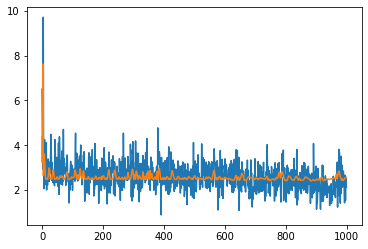

In [20]:
plt.figure()
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.show()

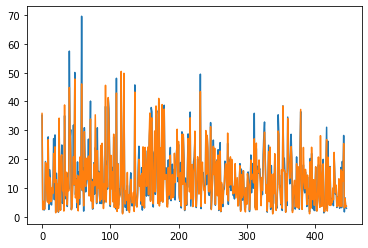

In [185]:
predictions = model.predict(images)
diff = np.abs(predictions - values)
#plt.hist(diff)
plt.plot(predictions)
plt.plot(values)

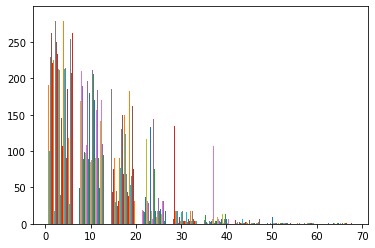

In [186]:
plt.hist(diff, bins=10)
plt.show()

In [188]:
df = annotations.copy()
df["Predictions"] = predictions
df["Diff"] = np.abs(df["Value"] - df["Predictions"])
df = df.sort_values("Diff", ascending=False)
df

,File,Value,Predictions,Diff
58,photo_59@02-07-2020_14-21-16.jpg,46.09,69.576981,23.486981
40,photo_41@13-06-2020_19-25-47.jpg,44.86,57.483154,12.623154
78,photo_79@18-07-2020_12-20-13.jpg,35.38,24.005575,11.374425
46,photo_47@18-06-2020_19-33-54.jpg,20.82,31.810614,10.990614
408,photo_417@25-09-2021_14-36-54.jpg,28.15,18.102680,10.047320
...,...,...,...,...
415,photo_424@28-09-2021_17-53-23.jpg,3.18,3.207471,0.027471
295,photo_300@25-04-2021_10-43-31.jpg,15.94,15.964162,0.024162
353,photo_359@02-07-2021_12-50-31.jpg,38.45,38.471642,0.021642
264,photo_269@20-03-2021_17-50-49.jpg,4.75,4.739193,0.010807


In [195]:
validation_image = (np.array(tf.keras.preprocessing.image.load_img("validation/photo_2022-01-03_17-48-12.jpg", target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) # real value is 22€
#validation_image = (np.array(tf.keras.preprocessing.image.load_img("validation/photo_2021-12-18_17-59-03.jpg", target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) # real value is 2.84
#validation_image = (np.array(tf.keras.preprocessing.image.load_img("validation/photo_2021-12-09_18-21-08.jpg", target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) # real value is 10.82

validation_image.shape

(480, 640, 1)

In [196]:
model.predict(np.array([validation_image]))

array([[17.628162]], dtype=float32)

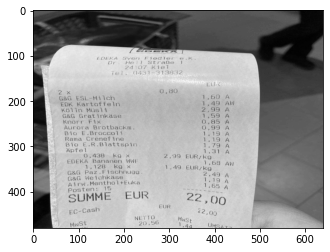

In [197]:
plt.imshow(validation_image,cmap="gray")